# Data Augmentation for Deep Learning <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F70_Data_Augmentation.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

This notebook illustrates the use of SimpleITK to perform data augmentation for deep learning. Note that the code is written so that the relevant functions work for both 2D and 3D images without modification.

Data augmentation is a model based approach for enlarging your training set. The problem being addressed is that the original dataset is not sufficiently representative of the general population of images. As a consequence, if we only train on the original dataset the resulting network will not generalize well to the population (overfitting). 

Using a model of the variations found in the general population and the existing dataset we generate additional images in the hope of capturing the population variability. Note that if the model you use is incorrect you can cause harm, you are generating observations that do not occur in the general population and are optimizing a function to fit them.

In [1]:
import SimpleITK as sitk
import numpy as np

# %matplotlib notebook
import gui

# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

OUTPUT_DIR = "Output"

## Before we start, a word of caution

**Whenever you sample there is potential for aliasing (Nyquist theorem).**

In many cases, data prepared for use with a deep learning network is resampled to a fixed size. When we perform data augmentation via spatial transformations we also perform resampling. 

Admittedly, the example below is exaggerated to illustrate the point, but it serves as a reminder that you may want to consider smoothing your images prior to resampling. 

The effects of aliasing also play a role in network performance stability:
A. Azulay, Y. Weiss, "Why do deep convolutional networks generalize so poorly to small image transformations?"  [CoRR abs/1805.12177](https://arxiv.org/abs/1805.12177), 2018.

In [2]:
%env SITK_SHOW_COMMAND /Applications/Slicer.app/Contents/MacOS/Slicer

env: SITK_SHOW_COMMAND=/Applications/Slicer.app/Contents/MacOS/Slicer


In [3]:
# The image we will resample (a grid).
grid_image = sitk.GridSource(
    outputPixelType=sitk.sitkUInt16,
    size=(512, 512),
    sigma=(0.1, 0.1),
    gridSpacing=(20.0, 20.0),
)
sitk.Show(grid_image, "original grid image")

# The spatial definition of the images we want to use in a deep learning framework (smaller than the original).
new_size = [100, 100]
reference_image = sitk.Image(new_size, grid_image.GetPixelIDValue())
reference_image.SetOrigin(grid_image.GetOrigin())
reference_image.SetDirection(grid_image.GetDirection())
reference_image.SetSpacing(
    [
        sz * spc / nsz
        for nsz, sz, spc in zip(new_size, grid_image.GetSize(), grid_image.GetSpacing())
    ]
)

# Resample without any smoothing.
sitk.Show(sitk.Resample(grid_image, reference_image), "resampled without smoothing")

# Resample after Gaussian smoothing.
sitk.Show(
    sitk.Resample(sitk.SmoothingRecursiveGaussian(grid_image, 2.0), reference_image),
    "resampled with smoothing",
)

## Load data

Load the images. You can work through the notebook using either the original 3D images or 2D slices from the original volumes. To do the latter, just uncomment the line in the cell below.

In [4]:
data = [
    sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd")),
    sitk.ReadImage(fdata("vm_head_mri.mha")),
    sitk.ReadImage(fdata("head_mr_oriented.mha")),
]
# Comment out the following line if you want to work in 3D. Note that in 3D some of the notebook visualizations are
# disabled.
data = [data[0][:, 160, :], data[1][:, :, 17], data[2][:, :, 0]]

Fetching nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd
Fetching vm_head_mri.mha
Fetching head_mr_oriented.mha


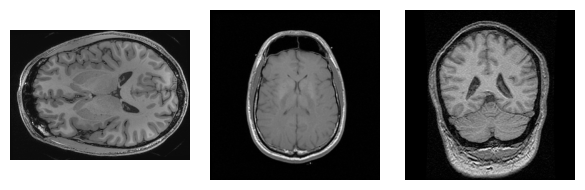

In [5]:
def disp_images(images, fig_size, wl_list=None):
    if images[0].GetDimension() == 2:
        gui.multi_image_display2D(
            image_list=images, figure_size=fig_size, window_level_list=wl_list
        )
    else:
        gui.MultiImageDisplay(
            image_list=images, figure_size=fig_size, window_level_list=wl_list
        )


disp_images(data, fig_size=(6, 2))

### Optional: cropping to region of interest

The original data often needs to be modified. In this example we would like to crop the images so that we only keep the informative regions. We can readily separate the foreground and background using an appropriate threshold, in our case we use Otsu's threshold selection method.

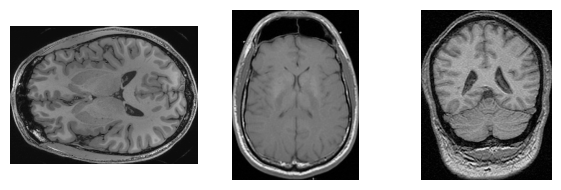

In [6]:
def threshold_based_crop(image):
    """
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.
    """
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute(sitk.OtsuThreshold(image, inside_value, outside_value))
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(
        image,
        bounding_box[int(len(bounding_box) / 2) :],
        bounding_box[0 : int(len(bounding_box) / 2)],
    )


modified_data = [threshold_based_crop(img) for img in data]

disp_images(modified_data, fig_size=(6, 2))

At this point we select the images we want to work with, skip the following cell if you want to work with the original data.

In [7]:
data = modified_data

### Optional: create corresponding segmentation reference data

Mimic the data available when performing semantic segmentation, the following cell creates corresponding "reference binary segmentation" data for each of the images. 

In [8]:
reference_segmentations = [sitk.OtsuThreshold(image, 0, 1) for image in data]

## Augmentation using spatial transformations

We next illustrate the generation of images by specifying a list of transformation parameter values representing a sampling of the transformation's parameter space.

The code below is agnostic to the specific transformation and it is up to the user to specify a valid list of transformation parameters (correct number of parameters and correct order). To learn more about the spatial transformations supported by SimpleITK you can explore the [Transforms notebook](22_Transforms.ipynb).

In most cases we can easily specify a regular grid in parameter space by specifying ranges of values for each of the parameters. In some cases specifying parameter values may be less intuitive (i.e. versor representation of rotation).

### Utility methods

Utilities for sampling a parameter space using a regular grid in a convenient manner (special care for 3D similarity).  

In [9]:
def parameter_space_regular_grid_sampling(*transformation_parameters):
    """
    Create a list representing a regular sampling of the parameter space.
    Args:
        *transformation_paramters : two or more numpy ndarrays representing parameter values. The order
                                    of the arrays should match the ordering of the SimpleITK transformation
                                    parametrization (e.g. Similarity2DTransform: scaling, rotation, tx, ty)
    Return:
        List of lists representing the regular grid sampling.

    Examples:
        #parametrization for 2D translation transform (tx,ty): [[1.0,1.0], [1.5,1.0], [2.0,1.0]]
        >>>> parameter_space_regular_grid_sampling(np.linspace(1.0,2.0,3), np.linspace(1.0,1.0,1))
    """
    return [
        [p.item() for p in parameter_values]
        for parameter_values in np.nditer(np.meshgrid(*transformation_parameters))
    ]


def similarity3D_parameter_space_regular_sampling(
    thetaX, thetaY, thetaZ, tx, ty, tz, scale
):
    """
    Create a list representing a regular sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parametrization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: numpy ndarrays with the Euler angle values to use, in radians.
        tx, ty, tz: numpy ndarrays with the translation values to use in mm.
        scale: numpy array with the scale values to use.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    """
    return [
        list(eul2quat(parameter_values[0], parameter_values[1], parameter_values[2]))
        + [p.item() for p in parameter_values[3:]]
        for parameter_values in np.nditer(
            np.meshgrid(thetaX, thetaY, thetaZ, tx, ty, tz, scale)
        )
    ]


def similarity3D_parameter_space_random_sampling(
    thetaX, thetaY, thetaZ, tx, ty, tz, scale, n
):
    """
    Create a list representing a random (uniform) sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parametrization uses the vector portion of a versor we don't have an
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: Ranges of Euler angle values to use, in radians.
        tx, ty, tz: Ranges of translation values to use in mm.
        scale: Range of scale values to use.
        n: Number of samples.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    """
    theta_x_vals = (thetaX[1] - thetaX[0]) * np.random.random(n) + thetaX[0]
    theta_y_vals = (thetaY[1] - thetaY[0]) * np.random.random(n) + thetaY[0]
    theta_z_vals = (thetaZ[1] - thetaZ[0]) * np.random.random(n) + thetaZ[0]
    tx_vals = (tx[1] - tx[0]) * np.random.random(n) + tx[0]
    ty_vals = (ty[1] - ty[0]) * np.random.random(n) + ty[0]
    tz_vals = (tz[1] - tz[0]) * np.random.random(n) + tz[0]
    s_vals = (scale[1] - scale[0]) * np.random.random(n) + scale[0]
    res = list(
        zip(theta_x_vals, theta_y_vals, theta_z_vals, tx_vals, ty_vals, tz_vals, s_vals)
    )
    return [list(eul2quat(*(p[0:3]))) + list(p[3:7]) for p in res]


def eul2quat(ax, ay, az, atol=1e-8):
    """
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectorial component of the quaternion.

    """
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r = np.zeros((3, 3))
    r[0, 0] = cz * cy
    r[0, 1] = cz * sy * sx - sz * cx
    r[0, 2] = cz * sy * cx + sz * sx

    r[1, 0] = sz * cy
    r[1, 1] = sz * sy * sx + cz * cx
    r[1, 2] = sz * sy * cx - cz * sx

    r[2, 0] = -sy
    r[2, 1] = cy * sx
    r[2, 2] = cy * cx

    # Compute quaternion:
    qs = 0.5 * np.sqrt(r[0, 0] + r[1, 1] + r[2, 2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs, 0.0, atol):
        i = np.argmax([r[0, 0], r[1, 1], r[2, 2]])
        j = (i + 1) % 3
        k = (j + 1) % 3
        w = np.sqrt(r[i, i] - r[j, j] - r[k, k] + 1)
        qv[i] = 0.5 * w
        qv[j] = (r[i, j] + r[j, i]) / (2 * w)
        qv[k] = (r[i, k] + r[k, i]) / (2 * w)
    else:
        denom = 4 * qs
        qv[0] = (r[2, 1] - r[1, 2]) / denom
        qv[1] = (r[0, 2] - r[2, 0]) / denom
        qv[2] = (r[1, 0] - r[0, 1]) / denom
    return qv

### Create reference domain 

All input images will be resampled onto the reference domain.

This domain is defined by two constraints: the number of pixels per dimension and the physical size we want the reference domain to occupy. The former is associated with the computational constraints of deep learning where using a small number of pixels is desired. The later is associated with the SimpleITK concept of an image, it occupies a  region in physical space which should be large enough to encompass the object of interest.

In [10]:
dimension = data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [
        (sz - 1) * spc if sz * spc > mx else mx
        for sz, spc, mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)
    ]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()

# Select arbitrary number of pixels per dimension, smallest size that yields desired results
# or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will
# often result in non-isotropic pixel spacing.
reference_size = [128] * dimension
reference_spacing = [
    phys_sz / (sz - 1) for sz, phys_sz in zip(reference_size, reference_physical_size)
]

# Another possibility is that you want isotropic pixels, then you can specify the image size for one of
# the axes and the others are determined by this choice. Below we choose to set the x axis to 128 and the
# spacing set accordingly.
# Uncomment the following lines to use this strategy.
# reference_size_x = 128
# reference_spacing = [reference_physical_size[0]/(reference_size_x-1)]*dimension
# reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
# spacing will not yield the correct coordinates resulting in a long debugging session.
reference_center = np.array(
    reference_image.TransformContinuousIndexToPhysicalPoint(
        np.array(reference_image.GetSize()) / 2.0
    )
)

### Data generation

Once we have a reference domain we can augment the data using any of the SimpleITK global domain transformations. In this notebook we use a similarity transformation (the generate_images function is agnostic to this specific choice).

Note that you also need to create the labels for your augmented images. If these are just classes then your processing is minimal. If you are dealing with segmentation you will also need to transform the segmentation labels so that they match the transformed image. The following function easily accommodates for this, just provide the labeled image as input and use the sitk.sitkNearestNeighbor interpolator so that you do not introduce labels that were not in the original segmentation.   

In [11]:
def augment_images_spatial(
    original_image,
    reference_image,
    T0,
    T_aug,
    transformation_parameters,
    output_prefix,
    output_suffix,
    interpolator=sitk.sitkLinear,
    default_intensity_value=0.0,
    additional_image_information=None,
):
    """
    Generate the resampled images based on the given transformations.
    Note: Images are written to disk with the useCompression flag
          set to true. This uses the default compression level for the user selected file
          format (via output_suffix).
    Args:
        original_image (SimpleITK image): The image which we will resample and transform.
        reference_image (SimpleITK image): The image onto which we will resample.
        T0 (SimpleITK transform): Transformation which maps points from the reference image coordinate system
            to the original_image coordinate system.
        T_aug (SimpleITK transform): Map points from the reference_image coordinate system back onto itself using the
               given transformation_parameters. The reason we use this transformation as a parameter
               is to allow the user to set its center of rotation to something other than zero.
        transformation_parameters (List of lists): parameter values which we use T_aug.SetParameters().
        output_prefix (string): output file name prefix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefix_p1_p2_..pn_.output_suffix), also determines
                                the file formt usef for writing to disk.
        interpolator: One of the SimpleITK interpolators.
        default_intensity_value: The value to return if a point is mapped outside the original_image domain.
        additional_image_information: (Iterable([SimpleITK.Image, Interpolator, default_intensity_value])): Apply the same
                                     transformations to this set of images using the given interpolators and intensity values.
                                     The iterable cannot be a zip because that will not allow for repeated iterations.
    """
    all_images = []  # Used only for display purposes in this notebook.
    for current_parameters in transformation_parameters:
        T_aug.SetParameters(current_parameters)
        # Augmentation is done in the reference image space, so we first map the points from the reference image space
        # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
        T_all = sitk.CompositeTransform(T0)
        T_all.AddTransform(T_aug)
        aug_image = sitk.Resample(
            original_image,
            reference_image,
            T_all,
            interpolator,
            default_intensity_value,
        )
        sitk.WriteImage(
            aug_image,
            output_prefix
            + "_"
            + "_".join(str(param) for param in current_parameters)
            + "_."
            + output_suffix,
            useCompression=True,
        )
        # Iterate over all additional images and apply the same transform to them using their specific
        # interpolator and default intensity value (e.g. for a segmentation image sitk.sitkNearestNeighbor and 0)
        if additional_image_information is not None:
            for i, (
                additional_image,
                additional_interpolator,
                additional_default_intensity_value,
            ) in enumerate(additional_image_information):
                additional_aug_image = sitk.Resample(
                    additional_image,
                    reference_image,
                    T_all,
                    additional_interpolator,
                    additional_default_intensity_value,
                )
                sitk.WriteImage(
                    additional_aug_image,
                    output_prefix
                    + "_"
                    + "_".join(str(param) for param in current_parameters)
                    + "_"
                    + f"additional_image_{i}"
                    + "."
                    + output_suffix,
                    useCompression=True,
                )
        all_images.append(aug_image)  # Used only for display purposes in this notebook.
    return all_images  # Used only for display purposes in this notebook.

Before we can use the generate_images function we need to compute the transformation which will map points between the reference image and the current image as shown in the code cell below. 

Note that it is very easy to generate large amounts of data using a regular grid sampling in the transformation parameter space (`similarity3D_parameter_space_regular_sampling`), the calls to np.linspace with $m$ parameters each having $n$ values results in $n^m$ images, so don't forget that these images are also saved to disk. **If you run the code below with regular grid sampling for 3D data you will generate 6561 volumes ($3^7$ parameter combinations times 3 volumes).**

By default, the cell below uses random uniform sampling in the transformation parameter space (`similarity3D_parameter_space_random_sampling`). If you want to try regular sampling, uncomment the commented out code.

Populating font family aliases took 2328 ms. Replace uses of missing font family ".SF NS Text" with one that exists to avoid this cost. 
Populating font family aliases took 2011 ms. Replace uses of missing font family ".SF NS Text" with one that exists to avoid this cost. 
Populating font family aliases took 2238 ms. Replace uses of missing font family ".SF NS Text" with one that exists to avoid this cost. 


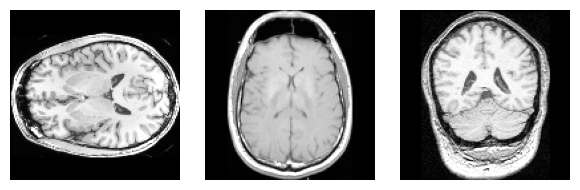

In [12]:
aug_transform = (
    sitk.Similarity2DTransform() if dimension == 2 else sitk.Similarity3DTransform()
)

all_images = []

for index, img in enumerate(data):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform(transform)
    centered_transform.AddTransform(centering_transform)

    # Set the augmenting transform's center so that rotation is around the image center.
    aug_transform.SetCenter(reference_center)

    if dimension == 2:
        # The parameters are scale (+-10%), rotation angle (+-10 degrees), x translation, y translation
        transformation_parameters_list = parameter_space_regular_grid_sampling(
            np.linspace(0.9, 1.1, 3),
            np.linspace(-np.pi / 18.0, np.pi / 18.0, 3),
            np.linspace(-10, 10, 3),
            np.linspace(-10, 10, 3),
        )
    else:
        transformation_parameters_list = similarity3D_parameter_space_random_sampling(
            thetaX=(-np.pi / 18.0, np.pi / 18.0),
            thetaY=(-np.pi / 18.0, np.pi / 18.0),
            thetaZ=(-np.pi / 18.0, np.pi / 18.0),
            tx=(-10.0, 10.0),
            ty=(-10.0, 10.0),
            tz=(-10.0, 10.0),
            scale=(0.9, 1.1),
            n=10,
        )
    #         transformation_parameters_list = similarity3D_parameter_space_regular_sampling(np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-np.pi/18.0,np.pi/18.0,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(-10,10,3),
    #                                                                                        np.linspace(0.9,1.1,3))
    additional_image_information = None
    if reference_segmentations:
        all_additional_image_information = list(
            zip(
                reference_segmentations,
                [sitk.sitkNearestNeighbor] * len(reference_segmentations),
                [0] * len(reference_segmentations),
            )
        )
    generated_images = augment_images_spatial(
        img,
        reference_image,
        centered_transform,
        aug_transform,
        transformation_parameters_list,
        os.path.join(OUTPUT_DIR, "spatial_aug" + str(index)),
        "nrrd",
        additional_image_information=[all_additional_image_information[index]],
    )

    if (
        dimension == 2
    ):  # in 2D we join all of the images into a 3D volume which we use for display.
        all_images.append(sitk.JoinSeries(generated_images))
# If working in 2D, display the resulting set of images.
if dimension == 2:
    gui.MultiImageDisplay(image_list=all_images, shared_slider=True, figure_size=(6, 2))

### What about flipping

Reflection using SimpleITK can be done in one of several ways:
1. Use an affine transform with the matrix component set to a reflection matrix. The columns of the matrix correspond to the $\mathbf{x}, \mathbf{y}$ and $\mathbf{z}$ axes. The reflection matrix is constructed using the plane, 3D,  or axis, 2D, which we want to reflect through with the standard basis vectors, $\mathbf{e}_i, \mathbf{e}_j$, and the remaining basis vector set to $-\mathbf{e}_k$.  
    * Reflection about $xy$ plane: $[\mathbf{e}_1, \mathbf{e}_2, -\mathbf{e}_3]$.
    * Reflection about $xz$ plane: $[\mathbf{e}_1, -\mathbf{e}_2, \mathbf{e}_3]$.
    * Reflection about $yz$ plane: $[-\mathbf{e}_1, \mathbf{e}_2, \mathbf{e}_3]$.
2. Use the native slicing operator(e.g. img[:,::-1,:]), or the FlipImageFilter after the image is resampled onto the reference image grid. 

We prefer option 1 as it is computationally more efficient. It combines all transformation prior to resampling, while the other approach performs resampling onto the reference image grid followed by the reflection operation. An additional difference is that using slicing or the FlipImageFilter will also modify the image origin while the resampling approach keeps the spatial location of the reference image origin intact. This minor difference is of no concern in deep learning as the content of the images is the same, but in SimpleITK two images are considered equivalent iff their content and spatial extent are the same.

The following two cells correspond to the two approaches:

In [13]:
%%timeit -n1 -r1
# Approach 1, using an affine transformation

flipped_images = []
for index, img in enumerate(data):
    # Compute the transformation which maps between the reference and current image (same as done above).
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform([transform, centering_transform])

    flipped_transform = sitk.AffineTransform(dimension)
    flipped_transform.SetCenter(
        reference_image.TransformContinuousIndexToPhysicalPoint(
            np.array(reference_image.GetSize()) / 2.0
        )
    )
    if dimension == 2:  # matrices in SimpleITK specified in row major order
        flipped_transform.SetMatrix([1, 0, 0, -1])
    else:
        flipped_transform.SetMatrix([1, 0, 0, 0, -1, 0, 0, 0, 1])
    centered_transform.AddTransform(flipped_transform)

    # Resample onto the reference image
    flipped_images.append(
        sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    )
# Uncomment the following line to display the images (we don't want to time this)
# disp_images(flipped_images, fig_size=(6,2))

31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n1 -r1

# Approach 2, flipping after resampling

flipped_images = []
for index, img in enumerate(data):
    # Compute the transformation which maps between the reference and current image (same as done above).
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(
        img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0)
    )
    centering_transform.SetOffset(
        np.array(transform.GetInverse().TransformPoint(img_center) - reference_center)
    )
    centered_transform = sitk.CompositeTransform([transform, centering_transform])
    # Resample onto the reference image
    resampled_img = sitk.Resample(
        img, reference_image, centered_transform, sitk.sitkLinear, 0.0
    )
    # We flip on the y axis (x, z are done similarly)
    if dimension == 2:
        flipped_images.append(resampled_img[:, ::-1])
    else:
        flipped_images.append(resampled_img[:, ::-1, :])
# Uncomment the following line to display the images (we don't want to time this)
# disp_images(flipped_images, fig_size=(6,2))

17.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Radial Distortion

Some 2D medical imaging modalities, such as endoscopic video and X-ray images acquired with C-arms using image intensifiers, exhibit radial distortion. The common model for such distortion was described by Brown ["Close-range camera calibration", Photogrammetric Engineering, 37(8):855–866, 1971]:
$$
\mathbf{p}_u = \mathbf{p}_d + (\mathbf{p}_d-\mathbf{p}_c)(k_1r^2 + k_2r^4 + k_3r^6 + \ldots)
$$

where:
* $\mathbf{p}_u$ is a point in the undistorted image
* $\mathbf{p}_d$ is a point in the distorted image
* $\mathbf{p}_c$ is the center of distortion
* $r = \|\mathbf{p}_d-\mathbf{p}_c\|$
* $k_i$ are coefficients of the radial distortion


Using SimpleITK operators we represent this transformation using a deformation field as follows:

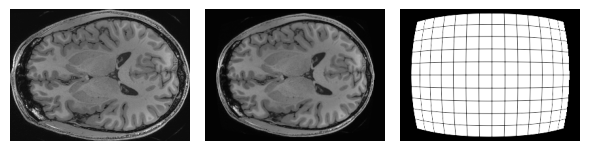

In [15]:
def radial_distort(image, k1, k2, k3, distortion_center=None):
    c = distortion_center
    if not c:  # The default distortion center coincides with the image center
        c = np.array(
            image.TransformContinuousIndexToPhysicalPoint(
                np.array(image.GetSize()) / 2.0
            )
        )

    # Compute the vector image (p_d - p_c)
    delta_image = sitk.PhysicalPointSource(
        sitk.sitkVectorFloat64,
        image.GetSize(),
        image.GetOrigin(),
        image.GetSpacing(),
        image.GetDirection(),
    )
    delta_image_list = [
        sitk.VectorIndexSelectionCast(delta_image, i) - c[i] for i in range(len(c))
    ]

    # Compute the radial distortion expression
    r2_image = sitk.NaryAdd([img**2 for img in delta_image_list])
    r4_image = r2_image**2
    r6_image = r2_image * r4_image
    disp_image = k1 * r2_image + k2 * r4_image + k3 * r6_image
    displacement_image = sitk.Compose([disp_image * img for img in delta_image_list])

    displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)
    return sitk.Resample(image, image, displacement_field_transform)


k1 = 0.00001
k2 = 0.0000000000001
k3 = 0.0000000000001
original_image = data[0]
distorted_image = radial_distort(original_image, k1, k2, k3)
# Use a grid image to highlight the distortion.
grid_image = sitk.GridSource(
    outputPixelType=sitk.sitkUInt16,
    size=original_image.GetSize(),
    sigma=[0.1] * dimension,
    gridSpacing=[20.0] * dimension,
)
grid_image.CopyInformation(original_image)
distorted_grid = radial_distort(grid_image, k1, k2, k3)
disp_images([original_image, distorted_image, distorted_grid], fig_size=(6, 2))

### Transferring deformations - exercise for the interested reader

Using SimpleITK we can readily transfer deformations from a spatio-temporal data set to another spatial data set to simulate temporal behavior. Case in point, using a 4D (3D+time) CT of the thorax we can estimate the respiratory motion using non-rigid registration and [Free Form Deformation](65_Registration_FFD.ipynb) or [displacement field](66_Registration_Demons.ipynb) transformations. We can then register a new spatial data set to the original spatial CT (non-rigidly) followed by application of the temporal deformations.

Note that unlike the arbitrary spatial transformations we used for data-augmentation above this approach is more computationally expensive as it involves multiple non-rigid registrations. Also note that as the goal is to use the estimated transformations to create plausible deformations you may be able to relax the required registration accuracy.



## Augmentation using intensity modifications

SimpleITK has many filters that are potentially relevant for data augmentation via modification of intensities. For example:
* Image smoothing, always read the documentation carefully, similar filters use use different parametrization $\sigma$ vs. variance ($\sigma^2$):
  * [Discrete Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1DiscreteGaussianImageFilter.html)
  * [Recursive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1RecursiveGaussianImageFilter.html)
  * [Smoothing Recursive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SmoothingRecursiveGaussianImageFilter.html)

* Edge preserving image smoothing:
  * [Bilateral image filtering](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1BilateralImageFilter.html), edge preserving smoothing.
  * [Median filtering](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1MedianImageFilter.html)

* Adding noise to your images:
  * [Additive Gaussian](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1AdditiveGaussianNoiseImageFilter.html)
  * [Salt and Pepper / Impulse](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SaltAndPepperNoiseImageFilter.html)
  * [Shot/Poisson](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ShotNoiseImageFilter.html)
  * [Speckle/multiplicative](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1SpeckleNoiseImageFilter.html)
  
* [Adaptive Histogram Equalization](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1AdaptiveHistogramEqualizationImageFilter.html)

In [16]:
def augment_images_intensity(image_list, output_prefix, output_suffix):
    """
    Generate intensity modified images from the originals.
    Args:
        image_list (iterable containing SimpleITK images): The images which we whose intensities we modify.
        output_prefix (string): output file name prefix (file name: output_prefixi_FilterName.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefixi_FilterName.output_suffix).
    """

    # Create a list of intensity modifying filters, which we apply to the given images
    filter_list = []

    # Smoothing filters

    filter_list.append(sitk.SmoothingRecursiveGaussianImageFilter())
    filter_list[-1].SetSigma(2.0)

    filter_list.append(sitk.DiscreteGaussianImageFilter())
    filter_list[-1].SetVariance(4.0)

    filter_list.append(sitk.BilateralImageFilter())
    filter_list[-1].SetDomainSigma(4.0)
    filter_list[-1].SetRangeSigma(8.0)

    filter_list.append(sitk.MedianImageFilter())
    filter_list[-1].SetRadius(8)

    # Noise filters using default settings

    # Filter control via SetMean, SetStandardDeviation.
    filter_list.append(sitk.AdditiveGaussianNoiseImageFilter())

    # Filter control via SetProbability
    filter_list.append(sitk.SaltAndPepperNoiseImageFilter())

    # Filter control via SetScale
    filter_list.append(sitk.ShotNoiseImageFilter())

    # Filter control via SetStandardDeviation
    filter_list.append(sitk.SpeckleNoiseImageFilter())

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(1.0)
    filter_list[-1].SetBeta(0.0)

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(0.0)
    filter_list[-1].SetBeta(1.0)

    aug_image_lists = []  # Used only for display purposes in this notebook.
    for i, img in enumerate(image_list):
        aug_image_lists.append([f.Execute(img) for f in filter_list])
        for aug_image, f in zip(aug_image_lists[-1], filter_list):
            sitk.WriteImage(
                aug_image,
                output_prefix + str(i) + "_" + f.GetName() + "." + output_suffix,
            )
    return aug_image_lists

Modify the intensities of the original images using the set of SimpleITK filters described above. If we are working with 2D images the results will be displayed inline.

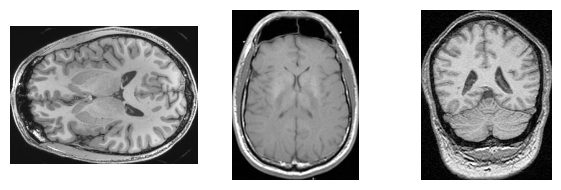

In [17]:
intensity_augmented_images = augment_images_intensity(
    data, os.path.join(OUTPUT_DIR, "intensity_aug"), "mha"
)

# in 2D we join all of the images into a 3D volume which we use for display.
if dimension == 2:

    def list2_float_volume(image_list):
        return sitk.JoinSeries([sitk.Cast(img, sitk.sitkFloat32) for img in image_list])

    all_images = [list2_float_volume(imgs) for imgs in intensity_augmented_images]

    # Compute reasonable window-level values for display (just use the range of intensity values
    # from the original data).
    original_window_level = []
    statistics_image_filter = sitk.StatisticsImageFilter()
    for img in data:
        statistics_image_filter.Execute(img)
        max_intensity = statistics_image_filter.GetMaximum()
        min_intensity = statistics_image_filter.GetMinimum()
        original_window_level.append(
            (max_intensity - min_intensity, (max_intensity + min_intensity) / 2.0)
        )
    gui.MultiImageDisplay(
        image_list=all_images,
        shared_slider=True,
        figure_size=(6, 2),
        window_level_list=original_window_level,
    )

SimpleITK has a sigmoid filter that allows us to map intensities via this nonlinear function to our desired range. Unlike the standard sigmoid settings that are applied when used as an activation function, the sigmoid filter is not necessarily centered on zero and the minimum and maximum output values are not necessarily 0 and 1.
The filter itself is defined as:
$$f(I) = (max_{output} - min_{output}) \frac{1}{1+ e^{-\frac{I-\beta}{\alpha}}} + min_{output}$$

Where $\alpha$ is the curve steepness (the larger the $\alpha$ the steeper the slope, the smaller the $\alpha$ the closer we get to a linear mapping in the output range) and $\beta$ is the intensity value for the sigmoid midpoint.

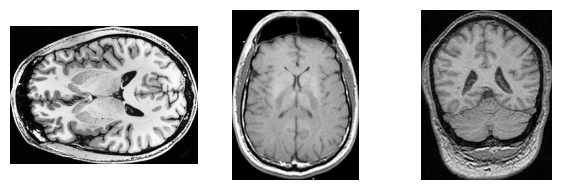

In [18]:
def sigmoid_mapping(
    image, curve_steepness, output_min=0, output_max=1.0, intensity_midpoint=None
):
    """
    Map the image using a sigmoid function.
    Args:
        image (SimpleITK image): scalar input image.
        curve_steepness: Control the sigmoid steepness, the larger the number the steeper the curve.
        output_min: Minimum value for output image, default 0.0 .
        output_max: Maximum value for output image, default 1.0 .
        intensity_midpoint: intensity value defining the sigmoid midpoint (x coordinate), default is the
                            median image intensity.
    Return:
        SimpleITK image with float pixel type.
    """
    if intensity_midpoint is None:
        intensity_midpoint = np.median(sitk.GetArrayViewFromImage(image))

    sig_filter = sitk.SigmoidImageFilter()
    sig_filter.SetOutputMinimum(output_min)
    sig_filter.SetOutputMaximum(output_max)
    sig_filter.SetAlpha(1.0 / curve_steepness)
    sig_filter.SetBeta(float(intensity_midpoint))
    return sig_filter.Execute(sitk.Cast(image, sitk.sitkFloat64))


# Change the order of magnitude of curve steepness [1.0,0.1,0.01] to see the effect of this parameter.
# Also change it from positive to negative.
disp_images(
    [sigmoid_mapping(img, curve_steepness=0.01) for img in data], fig_size=(6, 2)
)

While the sigmoid mapping visually appears to work as expected, it is always good to "trust but verify". In the next cell we create a 1D image and plot the resulting sigmoid mapped values, ensuring that what we expect is indeed what is happening. This also allows us to see the effects in a more controlled manner. 

To see the effects of various settings combinations try:
Setting the `curve_steepness` to [1.0,0.1,0.01, -0.01, -0.1, -1.0]
Setting the `intensity_midpoint` to [-50, 0, 50].

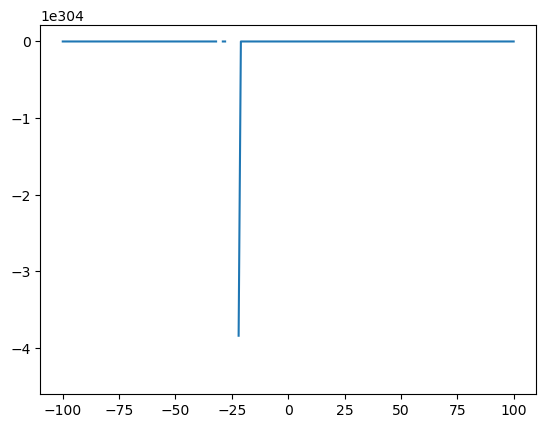

In [19]:
import matplotlib.pyplot as plt

# Create a 1D image with values in [-100,100].
arr_x = np.array([list(range(-100, 101))])
image1D = sitk.GetImageFromArray(arr_x)
plt.figure()
plt.plot(
    arr_x.ravel(),
    sitk.GetArrayViewFromImage(
        sigmoid_mapping(image1D, curve_steepness=1.0, intensity_midpoint=0)
    ).ravel(),
);

Histogram equalization, increasing the entropy, of images prior to using deep learning is a common preprocessing step. Unfortunately, ITK and consequentially SimpleITK do not have a histogram equalization filter.

The following cell illustrates this functionality for all integer scalar SimpleITK images (2D,3D).

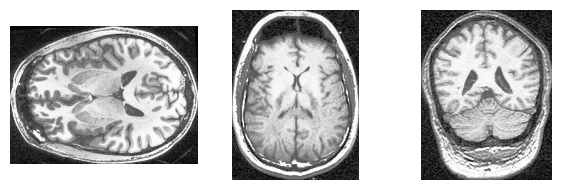

In [20]:
def histogram_equalization(
    image, min_target_range=None, max_target_range=None, use_target_range=True
):
    """
    Histogram equalization of scalar images whose single channel has an integer
    type. The goal is to map the original intensities so that resulting
    histogram is more uniform (increasing the image's entropy).
    Args:
        image (SimpleITK.Image): A SimpleITK scalar image whose pixel type
                                 is an integer (sitkUInt8,sitkInt8...
                                 sitkUInt64, sitkInt64).
        min_target_range (scalar): Minimal value for the target range. If None
                                   then use the minimal value for the scalar pixel
                                   type (e.g. 0 for sitkUInt8).
        max_target_range (scalar): Maximal value for the target range. If None
                                   then use the maximal value for the scalar pixel
                                   type (e.g. 255 for sitkUInt8).
        use_target_range (bool): If true, the resulting image has values in the
                                 target range, otherwise the resulting values
                                 are in [0,1].
    Returns:
        SimpleITK.Image: A scalar image with the same pixel type as the input image
                         or a sitkFloat64 (depending on the use_target_range value).
    """
    arr = sitk.GetArrayViewFromImage(image)

    i_info = np.iinfo(arr.dtype)
    if min_target_range is None:
        min_target_range = i_info.min
    else:
        min_target_range = np.max([i_info.min, min_target_range])
    if max_target_range is None:
        max_target_range = i_info.max
    else:
        max_target_range = np.min([i_info.max, max_target_range])

    min_val = arr.min()
    number_of_bins = arr.max() - min_val + 1
    # using ravel, not flatten, as it does not involve memory copy
    hist = np.bincount((arr - min_val).ravel(), minlength=number_of_bins)
    cdf = np.cumsum(hist)
    cdf = (cdf - cdf[0]) / (cdf[-1] - cdf[0])
    res = cdf[arr - min_val]
    if use_target_range:
        res = (min_target_range + res * (max_target_range - min_target_range)).astype(
            arr.dtype
        )
    return sitk.GetImageFromArray(res)


# cast the images to int16 because data[0] is float32 and the histogram equalization only works
# on integer types.
disp_images(
    [histogram_equalization(sitk.Cast(img, sitk.sitkInt16)) for img in data],
    fig_size=(6, 2),
)

Finally, you can easily create intensity variations that are specific to your domain, such as the spatially varying multiplicative and additive transformation shown below.

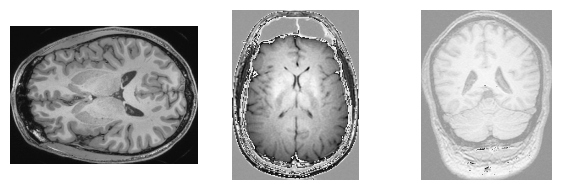

In [21]:
def mult_and_add_intensity_fields(original_image):
    """
    Modify the intensities using multiplicative and additive Gaussian bias fields.
    """
    # Gaussian image with same meta-information as original (size, spacing, direction cosine)
    # Sigma is half the image's physical size and mean is the center of the image.
    g_mult = sitk.GaussianSource(
        original_image.GetPixelIDValue(),
        original_image.GetSize(),
        [
            (sz - 1) * spc / 2.0
            for sz, spc in zip(original_image.GetSize(), original_image.GetSpacing())
        ],
        original_image.TransformContinuousIndexToPhysicalPoint(
            np.array(original_image.GetSize()) / 2.0
        ),
        255,
        original_image.GetOrigin(),
        original_image.GetSpacing(),
        original_image.GetDirection(),
    )

    # Gaussian image with same meta-information as original (size, spacing, direction cosine)
    # Sigma is 1/8 the image's physical size and mean is at 1/16 of the size
    g_add = sitk.GaussianSource(
        original_image.GetPixelIDValue(),
        original_image.GetSize(),
        [
            (sz - 1) * spc / 8.0
            for sz, spc in zip(original_image.GetSize(), original_image.GetSpacing())
        ],
        original_image.TransformContinuousIndexToPhysicalPoint(
            np.array(original_image.GetSize()) / 16.0
        ),
        255,
        original_image.GetOrigin(),
        original_image.GetSpacing(),
        original_image.GetDirection(),
    )

    return g_mult * original_image + g_add


disp_images([mult_and_add_intensity_fields(img) for img in data], fig_size=(6, 2))